# Advanced Lane Finding
---

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply the distortion correction to the raw image.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find lane boundary.
6. Determine curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---


In [1]:
#Import everything needed for the project

import numpy as np
import cv2
import pickle
import glob, os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc
from scipy.misc import imresize
import math


# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [2]:
#contants
#chessboard 
nx = 9
ny = 6

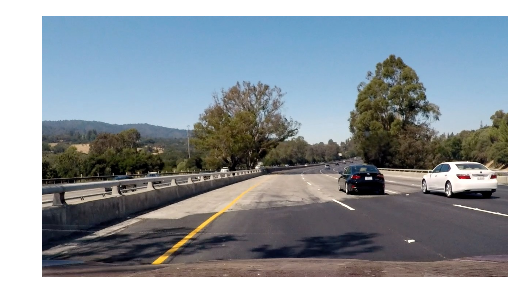

In [3]:
#Image to perform test on
image = mpimg.imread('test_images/test4.jpg')
#image = mpimg.imread('test_images/test3.jpg')
image_size = image.shape
plt.imshow(image);
plt.axis('off');


In [4]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #print(gray)
    # Sobel x or y
    if orient == "x":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
    if orient == "y":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
    abssxy = np.absolute(sobelxy) # Absolute xy derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssxy)/255 # Will use this to scale back to 8-bit scale
    abssxy = (abssxy/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold xy gradient
    retval, sxybinary = cv2.threshold(abssxy, thresh[0], thresh[1], cv2.THRESH_BINARY)

    return sxybinary

def mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100)):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    #print(gradmag)

    retval, mag_binary = cv2.threshold(gradmag, mag_thresh[0], mag_thresh[1], cv2.THRESH_BINARY)
    
    return mag_binary

def dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.4)):
    
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # To avoid error messages due to diving by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        
    return dir_binary

def rgb2hls(img, thresh=(0, 255)):    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    #print(s)
    
    # Threshold color channel
    retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    
    #print(s_binary)
    
    return s_binary




# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [5]:
def show_images(images,row,col, title):
        
    #Split the figure in x rows and y columns to put images
    figure, axes = plt.subplots(row,col, figsize=(24, 9))

    # hspace vertical space reserve for white space between subplots
    # wspace horizontal space reserve for white space between subplots
    figure.subplots_adjust(hspace=0.1)
    
    for i, ax in enumerate(axes.flat):
        image_shape = np.shape(images[i])
        ax.imshow(images[i].reshape(image_shape), cmap='gray')

        ax.set_xticks([])
        ax.set_yticks([])
        index = i +1
        msg = str("Test %g"%index + "_%s"%title)
        ax.set_title(msg)
        
    plt.subplots_adjust(left=0., right=0.4, top=0.9, bottom=0.)

    plt.show()

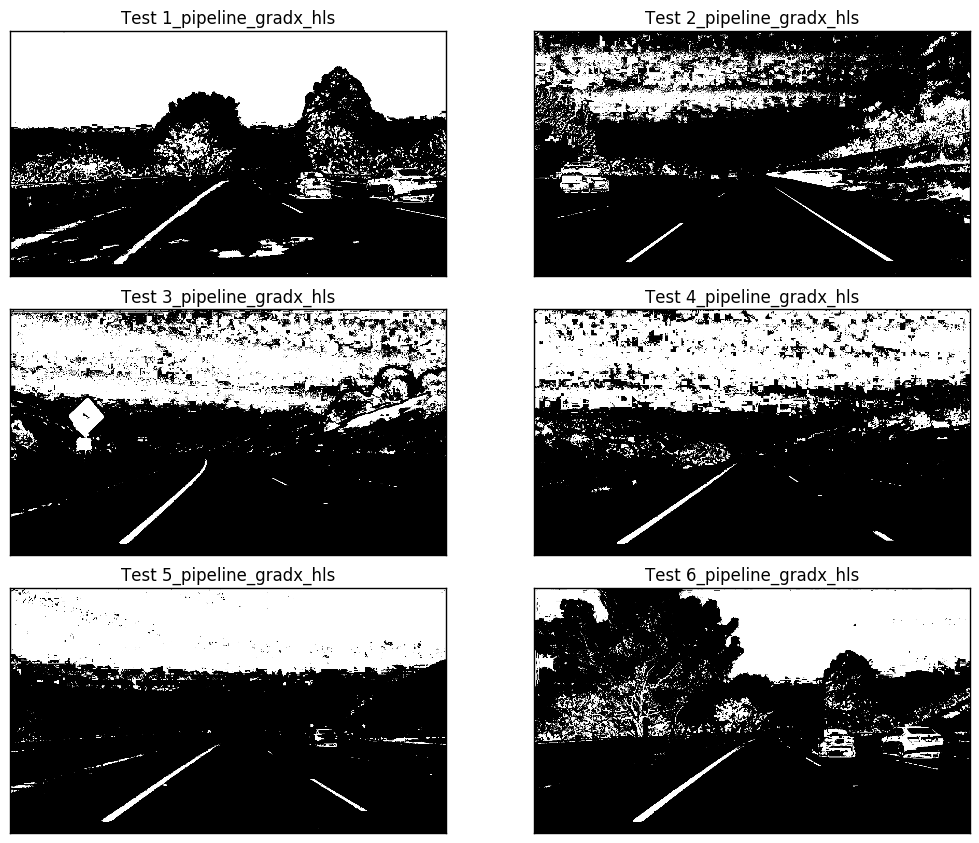

In [6]:
# Plot the result   
n_row = 3
n_col =2

def pipeline_gradx_hls(img):
    img = np.copy(img)

    #HLS
    s_binary= hls_select(img, thresh=(100, 255))
    
   
    # Gradient x
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(200, 250))

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sxbinary),sxbinary, s_binary))
    combined_binary = np.clip(cv2.bitwise_or(s_binary, sxbinary), 0, 1).astype('uint8')
    
    return combined_binary
    
images_filtered =[]
images = glob.glob('test_images/*.jpg')
for idx, image_name in enumerate(images):
    name = image_name.split('/')
    img =  mpimg.imread(image_name)
    filtered= pipeline_gradx_hls(img)
    #print (filtered)
    images_filtered.append(filtered)

show_images(images_filtered,n_row,n_col,"pipeline_gradx_hls")

In [7]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
#print(mtx.shape)
#print(dist.shape)

In [8]:
def undistortion(img, mtx, dist):
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undst

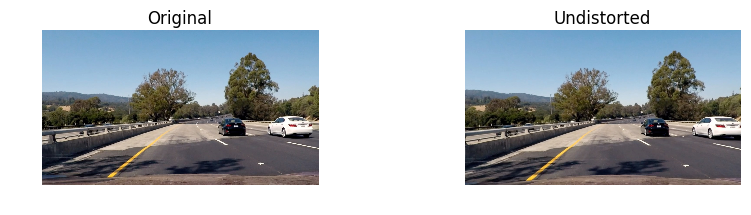

In [9]:
#Test undistortion function
image_undis = undistortion(image,mtx,dist)
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off');
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(image_undis)
plt.title('Undistorted')
plt.axis('off');

In [10]:
#Function to obtain a warped image

def warp(img, src, dst,image_size):  
        
    #Get the perspective transform.
    M = cv2.getPerspectiveTransform(src, dst)
    Minv =  cv2.getPerspectiveTransform(dst, src)
    
    #Warp an image using the perspective transform (M)
    warped = cv2.warpPerspective(img, M, (image_size[1],image_size[0]),  flags=cv2.INTER_LINEAR)   
    

    return warped, M, Minv

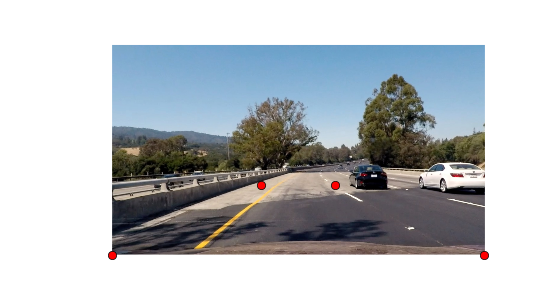

In [11]:
horizon = np.uint(2*image_size[0]/3)
bottom = np.uint(image_size[0])
center_lane = np.uint(image_size[1]/2)
offset = 0.2

x_left_bottom = center_lane - center_lane
x_right_bottom = 2*center_lane
x_right_upper = center_lane + offset*center_lane
x_left_upper = center_lane - offset*center_lane


source = np.float32([[x_left_bottom,bottom],[x_right_bottom,bottom],[x_right_upper,horizon],[x_left_upper,horizon]])

destination = np.float32([[0,image_size[0]],[image_size[1],image_size[0]],
                  [image_size[1],0],[0,0]])

#print(x_left_bottom,bottom)
#print(x_right_bottom,bottom)
#print(x_right_upper,horizon)
#print(x_left_upper,horizon)
plt.imshow(image_undis)
plt.plot(x_left_bottom,bottom,'ro')
plt.plot(x_right_bottom,bottom,'ro')
plt.plot(x_right_upper,horizon,'ro')
plt.plot(x_left_upper,horizon,'ro');
plt.axis('off');


In [12]:
#Test warp function with image
warped, M, Minv =  warp(image_undis,source,destination, image_size)


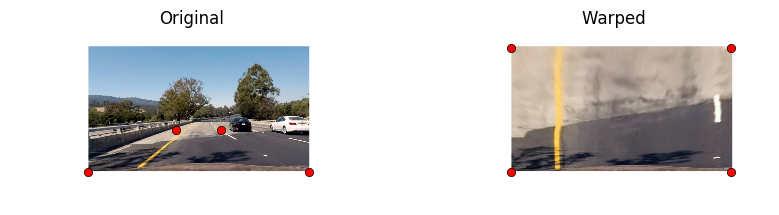

In [13]:
#Test warp function
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.imshow(image_undis)
plt.axis('off');
plt.title('Original')
plt.plot(x_left_bottom,bottom,'ro')
plt.plot(x_right_bottom,bottom,'ro')
plt.plot(x_right_upper,horizon,'ro')
plt.plot(x_left_upper,horizon,'ro')

#Test warp function
plt.subplot(1,2,2)
plt.imshow(warped)
plt.title('Warped')
plt.axis('off')
plt.plot(0,image_size[0],'ro')
plt.plot(image_size[1],image_size[0],'ro')
plt.plot(image_size[1],0,'ro')
plt.plot(0,0,'ro');


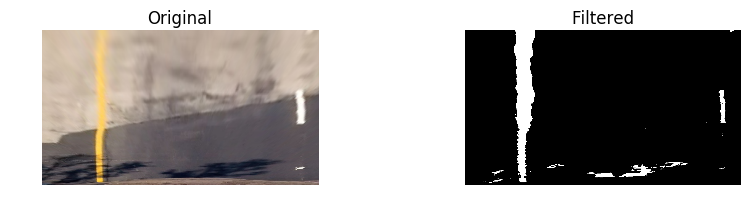

In [14]:
#Test pipeline in warped image
filtered= pipeline_gradx_hls(warped)

plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.axis('off');
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(filtered, cmap='gray')
plt.title('Filtered')
plt.axis('off');


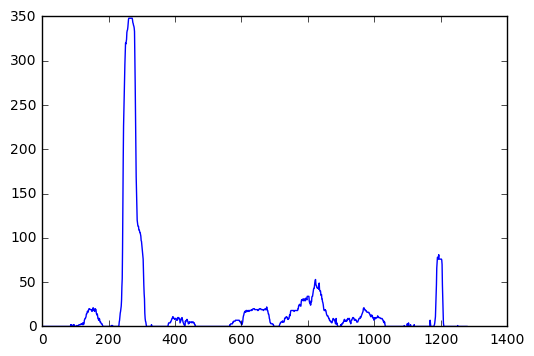

In [15]:
out = np.zeros(image.shape[1])
histogram = np.sum(filtered[image.shape[0]/2:,:], axis=0, out = out)
plt.plot(histogram);

In [16]:
def find_two_peaks(image, side='left'):
    out = np.zeros(img.shape[1])
    histogram = np.sum(image[img.shape[0]/2:,:], axis=0, out = out)
    
    first_half = len(histogram)/2
    left = histogram[:first_half]
    left_first_peak = np.argmax(left)
    left_value_peak = left[left_first_peak]
    
    right = histogram[first_half:]
    right_first_peak = np.argmax(right)
    right_value_peak = left[right_first_peak]
     
    
    dummy_left_array = left[left_first_peak:]

    counter = 0
    for index in dummy_left_array:
        if index != 0:
            counter = counter +1
            left_second_peak = left_first_peak+counter
        
        else:
            left_second_peak = left_first_peak+counter
            break
    
    left_center = left_first_peak + (left_second_peak - left_first_peak)/2
    
    
    
    dummy_right_array = right[right_first_peak:]

    counter = 0
    for index in dummy_right_array:
        if index != 0:
            counter = counter +1
            right_second_peak = right_first_peak+counter
        
        else:
            right_second_peak = right_first_peak+counter
            break
    
    
    right_center = (right_first_peak + (right_second_peak- right_first_peak)/2) + first_half 
    
    if side == 'left':
        center = left_center
        
    else:
        center = right_center
    
    return center

In [17]:
def find_two_peaks_image(image, side='left'):
    #plt.imshow(image,cmap='gray')

    out = np.zeros(image.shape[1])
    histogram = np.sum(image, axis=0, out = out)
    #plt.plot(histogram)
    
    first_half = len(histogram)/2
    left = histogram[:first_half]
    left_first_peak = np.argmax(left)
    left_value_peak = left[left_first_peak]
    
    right = histogram[first_half:]
    right_first_peak = np.argmax(right)
    right_value_peak = left[right_first_peak]
     
    
    dummy_left_array = left[left_first_peak:]

    counter = 0
    for index in dummy_left_array:
        if index != 0:
            counter = counter +1
            left_second_peak = left_first_peak+counter
            
        
        else:
            left_second_peak = left_first_peak+counter
            break
    
    left_center = left_first_peak + (left_second_peak - left_first_peak)/2
    
    
    
    dummy_right_array = right[right_first_peak:]

    counter = 0
    for index in dummy_right_array:
        if index != 0:
            counter = counter +1
            right_second_peak = right_first_peak+counter
        
        else:
            right_second_peak = right_first_peak+counter
            break
    
    
    right_center = (right_first_peak + (right_second_peak- right_first_peak)/2) + first_half 
    
    if side == 'left':
        center = left_center
        
    else:
        center = right_center
    
    return center

In [18]:
def sliding_window(image, left_start, delta):
    WIDTH = image.shape[1]
    WINDOW_WIDTH = 100
    #print(WIDTH)
    HEIGTH = image.shape[0]
    #print('start', left_start)
    
    sections = int(HEIGTH / delta)
    x_centers = []
    y_centers = []
    y_initials = []
    y_start = HEIGTH
    
    for index in range(1,sections+1):
        y_final = HEIGTH - index*delta
        y_initials.append(y_start)
        x_centers.append(left_start)
        image_test = image[y_final:y_start,left_start-25:left_start+ 25]
        #plt.imshow(image_test,cmap='gray')
        left_start = find_two_peaks_image(image_test, 'left') + left_start
        
        #x_centers.append(right_start)
        y_centers.append(y_final)
        y_start = y_final
        
    
    #print('X centers',x_centers)
    #print('Y centers',y_centers)
    #print('y_initials',y_initials) 
    
    return x_centers

In [19]:
center1= find_two_peaks(filtered)
x_center = sliding_window(filtered, center1, 10)

In [20]:
center2 = find_two_peaks(filtered, 'right')
x2_center = sliding_window(filtered, center2, 10)

In [21]:
def filter_pixels(image, x_center, width=100):
    rectangles = []
    x_pixels = []
    y_pixels = []

    for index_y in range(image.shape[0]-1,-1,-1):
        center = x_center[69-math.floor(index_y/10)]
        for index_x in range(image.shape[1]):
            
            if abs(index_x - center) < int(width/2):
                pixel = image[index_y][index_x]
                if pixel:
                    x_pixels.append(index_x)
                    y_pixels.append(index_y)
    
    #print('x_coords',x_pixels)
    #print('y_coords',y_pixels)
    return x_pixels, y_pixels
                    

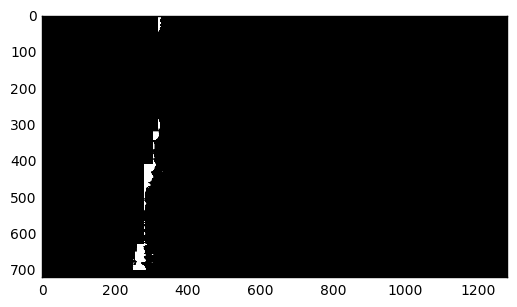

In [22]:
x_pixels,y_pixels = filter_pixels(filtered,x_center)
size = (720,1280)
new_image = np.zeros(size)

for x,y in zip (x_pixels, y_pixels):
    new_image[y][x] = 1

plt.imshow(new_image, cmap='gray')

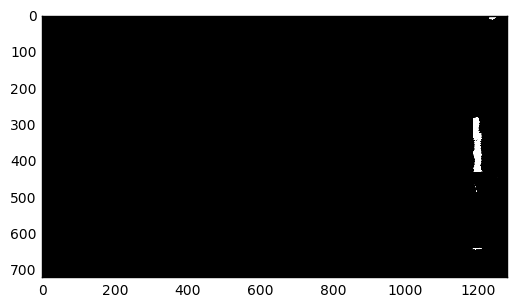

In [23]:
x_pixels_r,y_pixels_r = filter_pixels(filtered,x2_center)

new_image_r = np.zeros(size)

for i,j in zip (x_pixels_r, y_pixels_r):
    new_image_r[j][i] = 1

plt.imshow(new_image_r, cmap = 'gray')

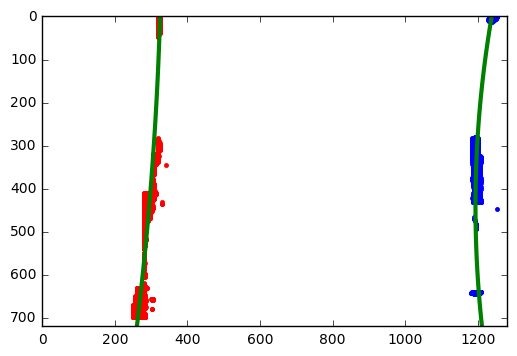

In [24]:
yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image

leftx = np.array(x_pixels)
y_pixels = np.array(y_pixels)


rightx = np.array(x_pixels_r)
y_pixels_r = np.array(y_pixels_r)


# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(y_pixels, leftx, 2)
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
right_fit = np.polyfit(y_pixels_r, rightx, 2)
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

# Plot up the fake data
plt.plot(leftx, y_pixels, '.', color='red')
plt.plot(rightx, y_pixels_r, '.', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, yvals, color='green', linewidth=3)
plt.plot(right_fitx, yvals, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [25]:
# Define y-value where we want radius of curvature
y_eval = np.max(yvals)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print("left curve:",left_curverad,"","","",'Rigth curve:', right_curverad)
# Example values: 1163.9    1213.7

left curve: 6906.10976833    Rigth curve: 2232.6746003


In [26]:
# Define conversions in x and y from pixels space to meters

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

left_fit_cr = np.polyfit(y_pixels*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(y_pixels_r*ym_per_pix, rightx*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 3380.7 m    3189.3 m

2573.84806724 m 1965.53080793 m


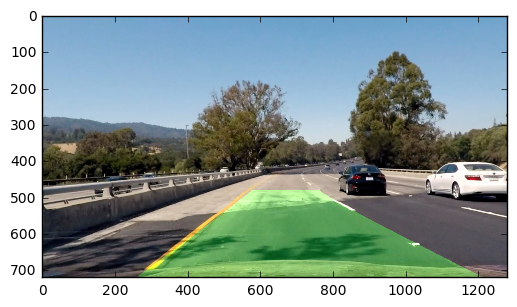

In [27]:
# Create an image to draw the lines on
warped = filtered
#print(type(warped))
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#print(color_warp.shape)
#print(type (left_fitx))
#print(yvals)


# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
pts = np.hstack((pts_left, pts_right))

#print(pts[0])
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
#print(newwarp.shape)
#print(undist.shape)
# Combine the result with the original image
result = cv2.addWeighted(image_undis, 1, newwarp, 0.3, 0)
plt.imshow(result)


In [32]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [38]:
def process_video(image):
    
    #first initialize lanes objects
    left_lane = Line()
    rigth_lane = Line()
    
    
    image_undis = undistortion(image, mtx, dist)
    image_size = image_undis.shape
    warped, M, Minv =  warp(image_undis,source,destination, image_size)
    warped = pipeline_gradx_hls(warped)
    
    center1= find_two_peaks(filtered)
    x_center = sliding_window(filtered, center1, 10)
    
    if center1 != 0:
        left_lane.detected = True
        left_lane.allx = x_center
           
    center2 = find_two_peaks(filtered, 'right')
    x2_center = sliding_window(filtered, center2, 10)
    
    if center2 != 0:
        right_lane.detected = True
        right_lane.allx = x2_center
    
    x_pixels,y_pixels = filter_pixels(filtered,x_center)
    x_pixels_r,y_pixels_r = filter_pixels(filtered,x2_center)
    
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image

    leftx = np.array(x_pixels)
    y_pixels = np.array(y_pixels)


    rightx = np.array(x_pixels_r)
    y_pixels_r = np.array(y_pixels_r)


    # Fit a second order polynomial to each fake lane line
    left_fit = np.polyfit(y_pixels, leftx, 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fit = np.polyfit(y_pixels_r, rightx, 2)
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    y_eval = np.max(yvals)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
        
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    left_fit_cr = np.polyfit(y_pixels*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(y_pixels_r*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
        
        
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #print(color_warp.shape)
    #print(type (left_fitx))
    #print(yvals)


    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    #print(pts[0])
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    #print(newwarp.shape)
    #print(undist.shape)
    # Combine the result with the original image
    result = cv2.addWeighted(image_undis, 1, newwarp, 0.3, 0)
    #plt.imshow(result)

    
    
    return result
    
    
    

In [39]:
process_video(image)

True


array([[[122, 168, 202],
        [122, 168, 202],
        [122, 168, 202],
        ..., 
        [109, 162, 202],
        [109, 162, 202],
        [109, 162, 202]],

       [[122, 168, 202],
        [122, 168, 202],
        [122, 168, 202],
        ..., 
        [109, 162, 202],
        [109, 162, 202],
        [109, 162, 202]],

       [[122, 168, 202],
        [122, 168, 202],
        [122, 168, 202],
        ..., 
        [109, 162, 202],
        [109, 162, 202],
        [109, 162, 202]],

       ..., 
       [[ 54,  71,  91],
        [ 57,  73,  93],
        [ 60,  75,  95],
        ..., 
        [136, 111, 104],
        [135, 110, 103],
        [133, 108, 101]],

       [[ 56,  71,  90],
        [ 57,  71,  90],
        [ 60,  74,  92],
        ..., 
        [135, 110, 103],
        [135, 110, 103],
        [135, 110, 103]],

       [[ 66,  79,  95],
        [ 63,  75,  91],
        [ 61,  72,  88],
        ..., 
        [134, 110, 102],
        [134, 109, 102],
        [133, 108,

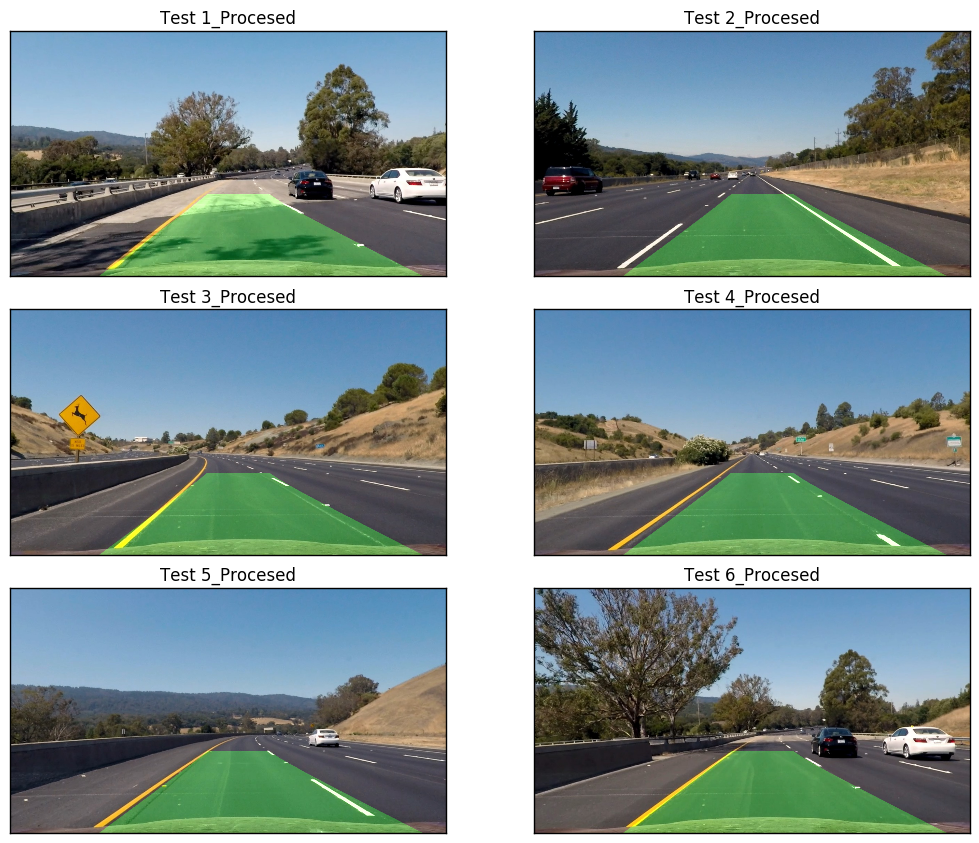

In [29]:
images_proccesed =[]
images = glob.glob('test_images/*.jpg')
for idx, image_name in enumerate(images):
    name = image_name.split('/')
    img =  mpimg.imread(image_name)
    procesed= process_video(img)
    #print (filtered)
    images_proccesed.append(procesed)

show_images(images_proccesed,n_row,n_col,"Procesed")

In [30]:
#To process the video 
output = 'output.mp4'
file = VideoFileClip("cut.mp4");
out = file.fl_image(process_video) #NOTE: this function expects color images!!
%time out.write_videofile(output, audio=False);

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|██████████| 262/262 [06:58<00:00,  1.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 11min 18s, sys: 2.86 s, total: 11min 21s
Wall time: 6min 59s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))